# 201710754 김종은

## 1문제: 2020년 8월 서울시 지하철호선별 역별 승하차 인원 정보
'서울시 지하철호선별 역별 승하차 인원 정보'를 검색하거나,
https://data.seoul.go.kr/dataList/OA-12914/S/1/datasetView.do
사이트를 방문한다. 분석할 파일은 'CARD_SUBWAY_MONTH_202008.csv'이다.
문제를 풀고 결과 출력을 예시해 놓았다. 동일하지 않아도 유사하게 출력하면 된다.

In [1]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

* 1) DataFrame 생성하고, 스키마는 자동인식하여 출력\
**답**

In [2]:
import os
CSdf = spark\
        .read\
        .options(header='true', inferschema='true', delimiter=',')\
        .csv('data/CARD_SUBWAY_MONTH_202008.csv')

In [3]:
CSdf.printSchema()
CSdf.show(5)

root
 |-- 사용일자: integer (nullable = true)
 |-- 노선명: string (nullable = true)
 |-- 역ID: string (nullable = true)
 |-- 역명: integer (nullable = true)
 |-- 승차총승객수: integer (nullable = true)
 |-- 하차총승객수: integer (nullable = true)
 |-- 등록일자: string (nullable = true)

+--------+------+----------------+-----+------------+------------+--------+
|사용일자|노선명|            역ID| 역명|승차총승객수|하차총승객수|등록일자|
+--------+------+----------------+-----+------------+------------+--------+
|20200801|중앙선|            오빈|  249|         239|    20200804|    null|
|20200801|중앙선|            아신|  467|         595|    20200804|    null|
|20200801|중앙선|            국수|  520|         598|    20200804|    null|
|20200801| 2호선|          한양대| 3244|        3022|    20200804|    null|
|20200801| 2호선|왕십리(성동구청)|11110|        9769|    20200804|    null|
+--------+------+----------------+-----+------------+------------+--------+
only showing top 5 rows



* 2) 컬럼명을 변경하고, 스키마 출력\
**답**

In [4]:
CSdf=CSdf.withColumnRenamed('사용일자', 'dataUse').withColumnRenamed('노선명', 'line').withColumnRenamed('역ID', 'stationID')\
    .withColumnRenamed('역명', 'station').withColumnRenamed('승차총승객수', 'NInPassengers')\
    .withColumnRenamed('하차총승객수', 'NOutPassengers').withColumnRenamed('등록일자','dateRegi')
CSdf.printSchema()

root
 |-- dataUse: integer (nullable = true)
 |-- line: string (nullable = true)
 |-- stationID: string (nullable = true)
 |-- station: integer (nullable = true)
 |-- NInPassengers: integer (nullable = true)
 |-- NOutPassengers: integer (nullable = true)
 |-- dateRegi: string (nullable = true)



* 3) 노선별 승하차합계가 가장 높은 역을 출력 (모든 노선 출력)\


In [5]:
from pyspark.sql.functions import to_date
from pyspark.sql.types import DateType, IntegerType, StringType
import pyspark.sql.functions as f

CSdf=CSdf.withColumn('SumInOut', CSdf.NInPassengers + CSdf.NOutPassengers)
CSdf.show()

+--------+------+-----------------------+-------+-------------+--------------+--------+--------+
| dataUse|  line|              stationID|station|NInPassengers|NOutPassengers|dateRegi|SumInOut|
+--------+------+-----------------------+-------+-------------+--------------+--------+--------+
|20200801|중앙선|                   오빈|    249|          239|      20200804|    null|20201043|
|20200801|중앙선|                   아신|    467|          595|      20200804|    null|20201399|
|20200801|중앙선|                   국수|    520|          598|      20200804|    null|20201402|
|20200801| 2호선|                 한양대|   3244|         3022|      20200804|    null|20203826|
|20200801| 2호선|       왕십리(성동구청)|  11110|         9769|      20200804|    null|20210573|
|20200801| 2호선|               상왕십리|   8110|         7289|      20200804|    null|20208093|
|20200801| 2호선|                   신당|   8703|         8731|      20200804|    null|20209535|
|20200801| 2호선|동대문역사문화공원(DDP)|   8183|         8474|      20200804|  

**답**

In [6]:
from pyspark.sql import functions as F
CSdf.join(CSdf.groupBy('line').agg(F.max('SumInOut').alias('SumInOut')),on='SumInOut',how='leftsemi').drop_duplicates(['line']).show()

+--------+--------+----------+--------------+-------+-------------+--------------+--------+
|SumInOut| dataUse|      line|     stationID|station|NInPassengers|NOutPassengers|dateRegi|
+--------+--------+----------+--------------+-------+-------------+--------------+--------+
|20218726|20200807|    일산선|          화정|  17591|        17916|      20200810|    null|
|20205351|20200814|    장항선|      온양온천|   4528|         4534|      20200817|    null|
|20247792|20200807|    경부선|        영등포|  43168|        46982|      20200810|    null|
|20206015|20200812|우이신설선|  북한산보국문|   5432|         5200|      20200815|    null|
|20205351|20200812|    분당선|          신갈|   4699|         4536|      20200815|    null|
|20247651|20200812|     7호선|가산디지털단지|  46117|        46836|      20200815|    null|
|20206576|20200812|    수인선|      인천논현|   5428|         5761|      20200815|    null|
|20218707|20200807|    안산선|          산본|  16478|        17897|      20200810|    null|
|20235924|20200812|     4호선|          혜화|  

* 4) 노선별 요일별 승하차인원 합계 (모든 노선 출력)

In [8]:
from pyspark.sql.functions import udf
from datetime import datetime
date = udf(lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d'))
CSdf = CSdf.withColumn('datep',date(CSdf['dataUse']))

In [9]:
CSdf.show(5)

+--------+------+----------------+-------+-------------+--------------+--------+--------+----------+
| dataUse|  line|       stationID|station|NInPassengers|NOutPassengers|dateRegi|SumInOut|     datep|
+--------+------+----------------+-------+-------------+--------------+--------+--------+----------+
|20200801|중앙선|            오빈|    249|          239|      20200804|    null|20201043|2020-08-01|
|20200801|중앙선|            아신|    467|          595|      20200804|    null|20201399|2020-08-01|
|20200801|중앙선|            국수|    520|          598|      20200804|    null|20201402|2020-08-01|
|20200801| 2호선|          한양대|   3244|         3022|      20200804|    null|20203826|2020-08-01|
|20200801| 2호선|왕십리(성동구청)|  11110|         9769|      20200804|    null|20210573|2020-08-01|
+--------+------+----------------+-------+-------------+--------------+--------+--------+----------+
only showing top 5 rows



In [10]:
from pyspark.sql.functions import date_format
CSdf = CSdf.withColumn('weekday', date_format('datep', 'E'))

In [11]:
CSdf.show(10)

+--------+------+-----------------------+-------+-------------+--------------+--------+--------+----------+-------+
| dataUse|  line|              stationID|station|NInPassengers|NOutPassengers|dateRegi|SumInOut|     datep|weekday|
+--------+------+-----------------------+-------+-------------+--------------+--------+--------+----------+-------+
|20200801|중앙선|                   오빈|    249|          239|      20200804|    null|20201043|2020-08-01|    Sat|
|20200801|중앙선|                   아신|    467|          595|      20200804|    null|20201399|2020-08-01|    Sat|
|20200801|중앙선|                   국수|    520|          598|      20200804|    null|20201402|2020-08-01|    Sat|
|20200801| 2호선|                 한양대|   3244|         3022|      20200804|    null|20203826|2020-08-01|    Sat|
|20200801| 2호선|       왕십리(성동구청)|  11110|         9769|      20200804|    null|20210573|2020-08-01|    Sat|
|20200801| 2호선|               상왕십리|   8110|         7289|      20200804|    null|20208093|2020-08-01|

**답**

In [12]:
CSweekSum=CSdf.groupBy('line').pivot('weekday').agg({"SumInOut":"sum"}).show()

+----------+----------+----------+----------+----------+----------+----------+----------+
|      line|       Fri|       Mon|       Sat|       Sun|       Thu|       Tue|       Wed|
+----------+----------+----------+----------+----------+----------+----------+----------+
|    일산선| 808395124|1010437381|1010319451|1010235636| 808383940| 808393127| 808392796|
|    장항선| 484860929| 606069487| 606063946| 606058420| 484854907| 484857571| 484857468|
|    경부선|3152874143|3940824196|3940449561|3940133615|3152768029|3152789327|3152794978|
|우이신설선|1050583774|1313216004|1313167396|1313141053|1050582715|1050586483|1050587942|
|    분당선|2809238836|3435543817|3455281248|3434771069|2788970586|2789009658|2768803828|
|     7호선|4123433410|5153934706|5152897879|5152372864|4123394044|4123436711|4123433745|
|    수인선|1050588760|1313214661|1313171127|1313138823|1050582601|1050584965|1050586007|
|    안산선|1050846248|1313503526|1313393601|1313300973|1050826620|1050840359|1050838751|
|     4호선|2102629179|2627972877|262

* 5) 노선별 요일별 승하차인원 그래프

In [13]:
CSweekSum=CSdf.groupBy('line').pivot('weekday').agg({"SumInOut":"sum"}).toPandas()

In [14]:
CSweekSum

,line,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,일산선,808395124,1010437381,1010319451,1010235636,808383940,808393127,808392796
1,장항선,484860929,606069487,606063946,606058420,484854907,484857571,484857468
2,경부선,3152874143,3940824196,3940449561,3940133615,3152768029,3152789327,3152794978
3,우이신설선,1050583774,1313216004,1313167396,1313141053,1050582715,1050586483,1050587942
4,분당선,2809238836,3435543817,3455281248,3434771069,2788970586,2789009658,2768803828
5,7호선,4123433410,5153934706,5152897879,5152372864,4123394044,4123436711,4123433745
6,수인선,1050588760,1313214661,1313171127,1313138823,1050582601,1050584965,1050586007
7,안산선,1050846248,1313503526,1313393601,1313300973,1050826620,1050840359,1050838751
8,4호선,2102629179,2627972877,2627425802,2627003684,2102581482,2102588996,2102590630
9,1호선,808840770,1010902468,1010677910,1010442174,808804370,808813210,808797690


In [15]:
my=CSweekSum.drop('line', 1).transpose()

In [16]:
my

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Fri,808395124,484860929,3152874143,1050583774,2809238836,4123433410,1050588760,1050846248,2102629179,808840770,...,3031250674,4244326342,1374322875,646761679,1617072711,1697177179,1050770990,4045276621,1131557563,2384370698
Mon,1010437381,606069487,3940824196,1313216004,3435543817,5153934706,1313214661,1313503526,2627972877,1010902468,...,3798984557,5315167094,1717805968,808392943,2021192027,2121432133,1313402811,5055626768,1414390988,2970260113
Sat,1010319451,606063946,3940449561,1313167396,3455281248,5152897879,1313171127,1313393601,2627425802,1010677910,...,3798594037,5314273162,1717544282,808256281,2020923212,2121354249,1313272640,5053793274,1414297414,2949914423
Sun,1010235636,606058420,3940133615,1313141053,3434771069,5152372864,1313138823,1313300973,2627003684,1010442174,...,3818552063,5313799053,1717409954,808185423,2020665884,2121287666,1313206990,5052610742,1414249246,2929559913
Thu,808383940,484854907,3152768029,1050582715,2788970586,4123394044,1050582601,1050826620,2102581482,808804370,...,3091829677,4244300204,1374304672,646752103,1617026950,1697164041,1050763509,4045136758,1131545840,2343934038
Tue,808393127,484857571,3152789327,1050586483,2789009658,4123436711,1050584965,1050840359,2102588996,808813210,...,3031240634,4244334032,1374321055,646758203,1617048535,1697169680,1050766410,4045209970,1131547289,2343944193
Wed,808392796,484857468,3152794978,1050587942,2768803828,4123433745,1050586007,1050838751,2102590630,808797690,...,3031242266,4244325671,1374320670,646760792,1617052844,1697166980,1050767248,4045204601,1131542158,2364136818


In [17]:
my.columns=['일산선','장항선','경부선','우이신설선','분당선','7호선','수인선','안산선','4호선','1호선','경의선','3호선','경강선','경춘선','9호선','6호선','5호선','8호선','과천선','경인선','중앙선','9호선2~3단계','2호선','공철','경원선']

**답**

C:\Users\joann\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\joann\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\joann\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\joann\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\joann\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54637 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\joann\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44221 missing from c

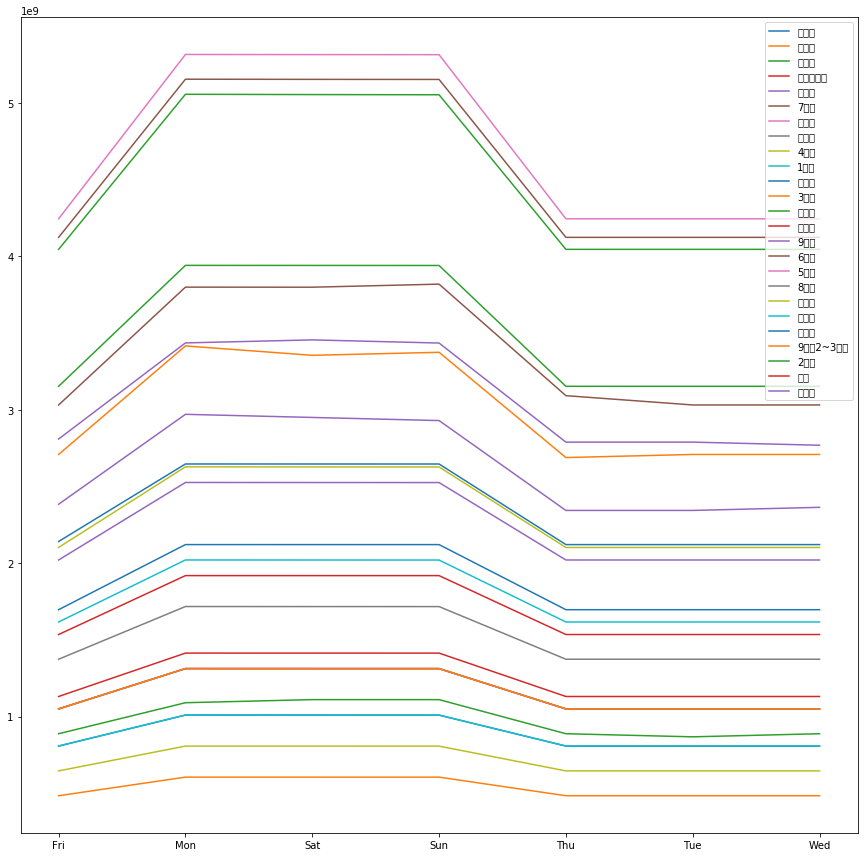

In [18]:
my.plot(kind='line', figsize=(15,15))

## 2문제: 한국의 코로나바이러스
데이터는 TimeProvince.csv를 다운로드해서 사용한다.
문제를 풀고 결과 출력을 예시해 놓았다. 동일하지 않아도 유사하게 출력하면 된다.


* 1) DataFrame 생성하고, 자동인식한 스키마를 출력\
**답**

In [19]:
import os
TPdf = spark\
        .read\
        .options(header='true', inferschema='true', delimiter=',')\
        .csv('data/TimeProvince.csv')

In [20]:
TPdf.printSchema()
TPdf.show(5)

root
 |-- date: string (nullable = true)
 |-- time: integer (nullable = true)
 |-- province: string (nullable = true)
 |-- confirmed: integer (nullable = true)
 |-- released: integer (nullable = true)
 |-- deceased: integer (nullable = true)

+----------+----+--------+---------+--------+--------+
|      date|time|province|confirmed|released|deceased|
+----------+----+--------+---------+--------+--------+
|2020-01-20|  16|   Seoul|        0|       0|       0|
|2020-01-20|  16|   Busan|        0|       0|       0|
|2020-01-20|  16|   Daegu|        0|       0|       0|
|2020-01-20|  16| Incheon|        1|       0|       0|
|2020-01-20|  16| Gwangju|        0|       0|       0|
+----------+----+--------+---------+--------+--------+
only showing top 5 rows



* 2) 3월의 데이터만 출력\
**답**

In [21]:
from pyspark.sql.functions import to_date, col, year, month

TPdf=TPdf.withColumn('date', to_date(TPdf['date'], 'yyyy-MM-dd')).withColumn('year', year("date")).withColumn('month', month("date"))

In [22]:
TPdf.filter(TPdf.month == 3).show()

+----------+----+-----------------+---------+--------+--------+----+-----+
|      date|time|         province|confirmed|released|deceased|year|month|
+----------+----+-----------------+---------+--------+--------+----+-----+
|2020-03-01|  16|            Seoul|       87|      11|       0|2020|    3|
|2020-03-01|  16|            Busan|       83|       0|       0|2020|    3|
|2020-03-01|  16|            Daegu|     2704|       6|      11|2020|    3|
|2020-03-01|  16|          Incheon|        6|       1|       0|2020|    3|
|2020-03-01|  16|          Gwangju|        9|       2|       0|2020|    3|
|2020-03-01|  16|          Daejeon|       13|       0|       0|2020|    3|
|2020-03-01|  16|            Ulsan|       20|       0|       0|2020|    3|
|2020-03-01|  16|           Sejong|        1|       0|       0|2020|    3|
|2020-03-01|  16|      Gyeonggi-do|       89|       8|       1|2020|    3|
|2020-03-01|  16|       Gangwon-do|       15|       0|       0|2020|    3|
|2020-03-01|  16|Chungche

* 3) 년x월별 건수\
**답**

In [23]:
from pyspark.sql import functions as F

TPdf.groupBy('year').pivot('month').agg(F.count('month')).show()

+----+---+---+---+---+---+---+
|year|  1|  2|  3|  4|  5|  6|
+----+---+---+---+---+---+---+
|2020|204|493|527|510|527|510|
+----+---+---+---+---+---+---+



* 4) 도별 첫 확진자 출현 (모든 도 출력)\
**답**

In [25]:
from pyspark.sql.window import Window
windowTP = (Window.partitionBy('province').orderBy('province')
             .rangeBetween(Window.unboundedPreceding, 0))
_TPdf = TPdf.where(F.col("confirmed")>0).drop_duplicates(['province'])
_TPdf.show()

+----------+----+-----------------+---------+--------+--------+----+-----+
|      date|time|         province|confirmed|released|deceased|year|month|
+----------+----+-----------------+---------+--------+--------+----+-----+
|2020-02-22|  16|           Sejong|        1|       0|       0|2020|    2|
|2020-02-22|  16|            Ulsan|        1|       0|       0|2020|    2|
|2020-02-21|  16|Chungcheongbuk-do|        1|       0|       0|2020|    2|
|2020-02-22|  16|       Gangwon-do|        6|       0|       0|2020|    2|
|2020-02-04|  16|          Gwangju|        1|       0|       0|2020|    2|
|2020-02-19|  16| Gyeongsangbuk-do|        2|       1|       0|2020|    2|
|2020-02-18|  16|            Daegu|        1|       0|       0|2020|    2|
|2020-02-19|  16| Gyeongsangnam-do|        3|       0|       0|2020|    2|
|2020-01-20|  16|          Incheon|        1|       0|       0|2020|    1|
|2020-02-21|  16|          Jeju-do|        1|       0|       0|2020|    2|
|2020-01-24|  16|      Gy

* 5) 도별 누적 확진자 (마지막 일 6월 30일 기준, 모든 도 출력)\
**답**

In [26]:
from pyspark.sql import Window
from pyspark.sql import functions as F

windowTP = (Window.partitionBy('province').orderBy('province')
             .rangeBetween(Window.unboundedPreceding, 0))
TPdf = TPdf.withColumn('cumulative_sum', F.sum('confirmed').over(windowTP)).orderBy(TPdf.date.desc()).drop_duplicates(['province'])
TPdf.show()

+----------+----+-----------------+---------+--------+--------+----+-----+--------------+
|      date|time|         province|confirmed|released|deceased|year|month|cumulative_sum|
+----------+----+-----------------+---------+--------+--------+----+-----+--------------+
|2020-06-30|   0|           Sejong|       50|      47|       0|2020|    6|          5111|
|2020-06-30|   0|            Ulsan|       55|      50|       1|2020|    6|          5269|
|2020-06-30|   0|Chungcheongbuk-do|       65|      60|       0|2020|    6|          5801|
|2020-06-30|   0|       Gangwon-do|       65|      54|       3|2020|    6|          5908|
|2020-06-30|   0|          Gwangju|       44|      32|       0|2020|    6|          3359|
|2020-06-30|   0| Gyeongsangbuk-do|     1389|    1328|      54|2020|    6|        161079|
|2020-06-30|   0|            Daegu|     6906|    6700|     189|2020|    6|        807506|
|2020-06-30|   0| Gyeongsangnam-do|      134|     128|       0|2020|    6|         13860|
|2020-06-3

## 문제 S-3: 키, 몸무게 상관관계

* 1) DataFrame 생성하고, 스키마를 출력\
**답**

In [27]:
tDf = spark\
    .read\
    .options(header='false', inferschema='true', delimiter='\t')\
    .csv(os.path.join('data', 'ds_spark_heightweight.txt'))\
    .withColumnRenamed('_c0', 'id').withColumnRenamed('_c1', 'height').withColumnRenamed('_c2', 'weight')
tDf.show(5)

+---+------+------+
| id|height|weight|
+---+------+------+
|  1| 65.78|112.99|
|  2| 71.52|136.49|
|  3|  69.4|153.03|
|  4| 68.22|142.34|
|  5| 67.79| 144.3|
+---+------+------+
only showing top 5 rows



In [28]:
tDf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)



* 2) BMI 컬럼 생성\
**답**

In [30]:
from pyspark.sql.types import DoubleType
bmi_udf = udf(lambda weight, height: weight/height/height*703, DoubleType())
tDf= tDf.withColumn("bmi", bmi_udf(tDf.weight, tDf.height))
tDf.show(5)

+---+------+------+------------------+
| id|height|weight|               bmi|
+---+------+------+------------------+
|  1| 65.78|112.99| 18.35724885581456|
|  2| 71.52|136.49| 18.75863128975672|
|  3|  69.4|153.03|22.336388891195835|
|  4| 68.22|142.34| 21.50100976190556|
|  5| 67.79| 144.3| 22.07447524407711|
+---+------+------+------------------+
only showing top 5 rows



* 3) weigth와 height의 Zscore 컬럼 생성\
**답**

In [31]:
from pyspark.sql import functions as F
import sys

tWindow = Window.rowsBetween(-sys.maxsize, sys.maxsize)
tDf = tDf.withColumn("zscoreW", (F.col('weight')-F.avg('weight').over(tWindow))/F.stddev('weight').over(tWindow))
tDf = tDf.withColumn("zscoreH", (F.col('height')-F.avg('height').over(tWindow))/F.stddev('height').over(tWindow))

In [32]:
tDf.show(5)

+---+------+------+------------------+-------------------+--------------------+
| id|height|weight|               bmi|            zscoreW|             zscoreH|
+---+------+------+------------------+-------------------+--------------------+
|  1| 65.78|112.99| 18.35724885581456|-1.2298965504184058| -1.2458467531235724|
|  2| 71.52|136.49| 18.75863128975672| 0.5933793097148594|  1.9011169693413281|
|  3|  69.4|153.03|22.336388891195835|   1.87665517042142|  0.7388237478037734|
|  4| 68.22|142.34| 21.50100976190556| 1.0472586195778204| 0.09188695468380685|
|  5| 67.79| 144.3| 22.07447524407711| 1.1993275849336167|-0.14386119874126027|
+---+------+------+------------------+-------------------+--------------------+
only showing top 5 rows



* 4) spark에서 위에 계산한 zscore를 사용하여 상관관계 계산\
**답**

In [33]:
zscoreW=tDf.select('zscoreW').rdd.map(lambda row : row[0]).collect()
zscoreH=tDf.select('zscoreH').rdd.map(lambda row : row[0]).collect()

In [34]:
cor = sum([(w * h) for w,h in zip(zscoreW, zscoreH)])/(len(zscoreW)-1)

In [35]:
print(cor)

0.5925221289063207


* 5) scipy를 사용하여 상관관계를 계산\
**답**

In [36]:
from scipy import stats
tDf.stat.corr("zscoreW","zscoreH")

0.5925221289063219